In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import os
import time

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../input/SP500_Sheet.csv', index_col=[0], parse_dates=True)
print((df.isna().sum()))
df.tail()

Close    0
dtype: int64


,Close
Date,
2019-11-14,3096.629883
2019-11-15,3120.459961
2019-11-18,3122.030029
2019-11-19,3120.179932
2019-11-20,3108.459961


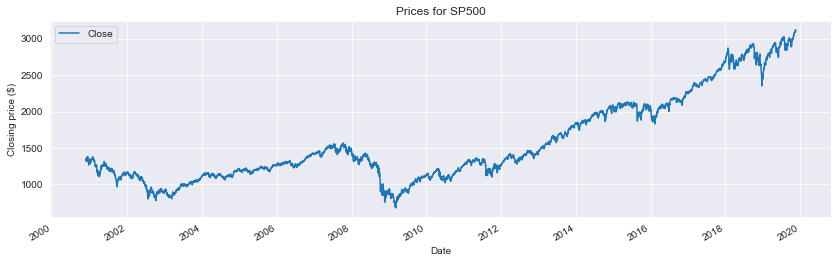

In [3]:
df.plot(figsize=(14, 4))
plt.title('Prices for SP500')
plt.ylabel('Closing price ($)')
plt.legend(loc='best')
plt.show()

In [4]:
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error

# Data Preparation

In [5]:
# Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# split a univariate sequence into samples
def split_sequence(sequence, n_steps, train_size):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    # Train_Test split
    split_X = int(len(X) * train_size)
    split_y = int(len(y) * train_size)
    X_train, y_train = np.array(X[:split_X]), np.array(y[:split_y]),

    split_x_val = int(len(X[int(split_X):]) * 0.5)
    split_y_val = int(len(y[int(split_y):]) * 0.5)
    print((split_x_val, split_y_val))

    X_test, y_test = np.array(X[split_X:(split_X + split_x_val)]), np.array(
        y[split_y:(split_y + split_y_val)])

    X_val, y_val = np.array(X[(split_X + split_x_val):]), np.array(
        y[(split_y + split_y_val):])

    return X_train, X_test, y_train, y_test, X_val, y_val

In [6]:
# define input sequence
raw_seq = list(df['Close'].values)
# choose a number of time steps
n_steps = 7
# split into samples
X_train, X_test, y_train, y_test, X_val, y_val = split_sequence(raw_seq,
                                                                n_steps,
                                                                train_size=0.9)
# summarize the data
print((len(X_train), len(X_test), len(X_val), len(y_train), len(y_test),
      len(y_val)))

model_names = {}  # This is to automate forecasts

(239, 239)
(4294, 239, 239, 4294, 239, 239)


# Prediction

## 1. Vanilla LSTM

In [7]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

# define model
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.LSTM(200,
                         activation='relu',
                         input_shape=(n_steps, n_features)),
    tf.keras.layers.Dense(1)
])

model_vanilla.compile(optimizer='adam', loss='mape')

print((model_vanilla.summary()))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# fit model
history_vanilla = model_vanilla.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=2,
    callbacks=[tf.keras.callbacks.EarlyStopping()],
    validation_data=(X_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4294 samples, validate on 239 samples
Epoch 1/50
4294/4294 - 5s - loss: 9.2694 - val_loss: 1.1812
Epoch 2/50
4294/4294 - 4s - loss: 1.5092 - val_loss: 1.3556


In [9]:
# demonstrate prediction
yhat = model_vanilla.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)

vanilla_name = '../models/vanilla_lstm.h5'
model_names[r2] = vanilla_name  # For automated forecasts
print(model_names)
model_vanilla.save(vanilla_name)

print(f'r2: {r2} Mape: {mape}')

{0.499: '../models/vanilla_lstm.h5'}
r2: 0.499 Mape: 3.581


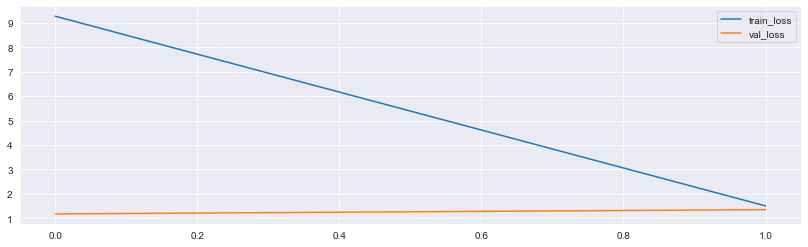

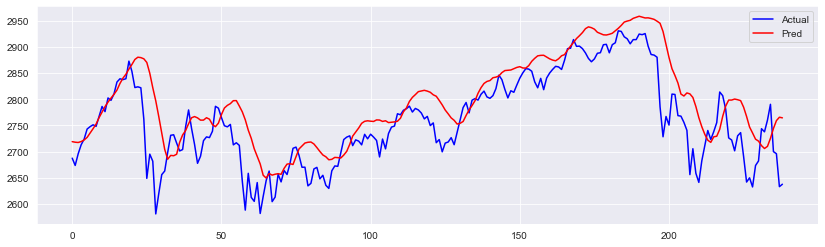

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(history_vanilla.history['loss'], label='train_loss')
plt.plot(history_vanilla.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

## 2. Stacked LSTM

In [11]:
# define model
model_stacked = tf.keras.Sequential([
    tf.keras.layers.LSTM(200,
                         activation='relu',
                         return_sequences=True,
                         input_shape=(n_steps, n_features)),
    tf.keras.layers.LSTM(200, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_stacked.compile(optimizer='adam', loss='mape')
print((model_stacked.summary()))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 200)            161600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# fit model
history_stacked = model_stacked.fit(
    X_train,
    y_train,
    epochs=200,
    verbose=2,
    callbacks=[tf.keras.callbacks.EarlyStopping()],
    validation_data=(X_val, y_val))

Train on 4294 samples, validate on 239 samples
Epoch 1/200
4294/4294 - 10s - loss: 7.3815 - val_loss: 1.3279
Epoch 2/200
4294/4294 - 8s - loss: 1.7291 - val_loss: 1.3135
Epoch 3/200
4294/4294 - 8s - loss: 1.8094 - val_loss: 1.3644


In [13]:
# demonstrate prediction
yhat = model_stacked.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)

stacked_name = '../models/stacked_lstm.h5'

model_names[r2] = stacked_name
model_stacked.save(stacked_name)

print(model_names)
print(f'r2: {r2} Mape: {mape}')

{0.499: '../models/vanilla_lstm.h5', 0.608: '../models/stacked_lstm.h5'}
r2: 0.608 Mape: 3.389


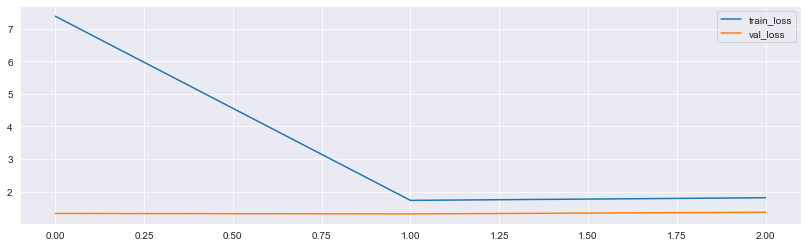

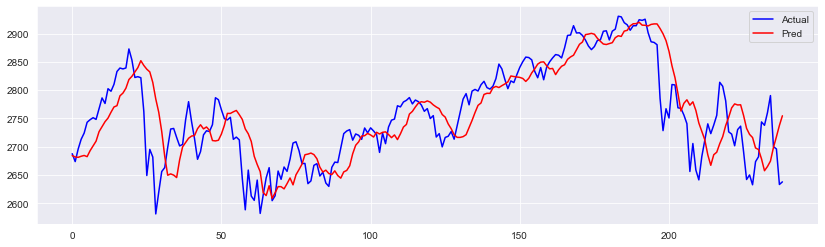

In [14]:
plt.figure(figsize=(14, 4))
plt.plot(history_stacked.history['loss'], label='train_loss')
plt.plot(history_stacked.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

## 3. Bidirectional LSTM

In [15]:
# define model
model_bidirectional = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu'),
                                  input_shape=(n_steps, n_features)),
    tf.keras.layers.Dense(1)
])

model_bidirectional.compile(optimizer='adam', loss='mape')
print((model_bidirectional.summary()))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 512)               528384    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 528,897
Trainable params: 528,897
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# fit model
history_bidirectional = model_bidirectional.fit(
    X_train,
    y_train,
    epochs=200,
    verbose=2,
    callbacks=[tf.keras.callbacks.EarlyStopping()],
    validation_data=(X_val, y_val))

Train on 4294 samples, validate on 239 samples
Epoch 1/200
4294/4294 - 14s - loss: 9.6781 - val_loss: 1.0363
Epoch 2/200
4294/4294 - 12s - loss: 1.3342 - val_loss: 1.0790


In [17]:
# demonstrate prediction
yhat = model_bidirectional.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)

bidirectional = '../models/bidirectional_lstm.h5'
model_bidirectional.save(bidirectional)

model_names[r2] = bidirectional
print(model_names)
print(f'r2: {r2} Mape: {mape}')

{0.499: '../models/vanilla_lstm.h5', 0.608: '../models/stacked_lstm.h5', 0.672: '../models/bidirectional_lstm.h5'}
r2: 0.672 Mape: 3.513


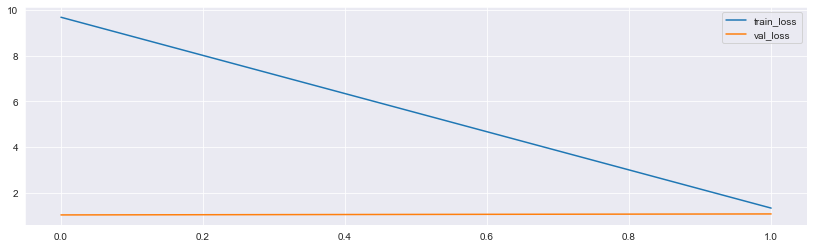

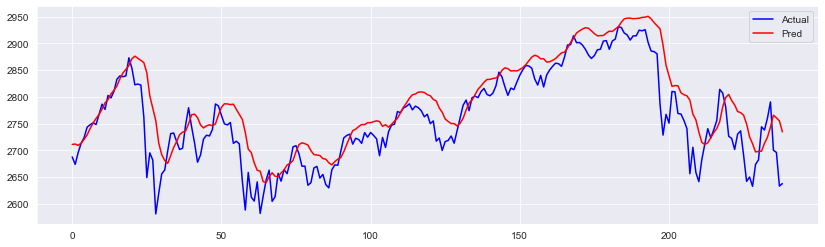

In [18]:
plt.figure(figsize=(14, 4))
plt.plot(history_bidirectional.history['loss'], label='train_loss')
plt.plot(history_bidirectional.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

In [19]:
def get_input_sequesnce(raw_seq):
    # define input sequence
    X, y = list(), list()
    n_steps = 7
    for i in range(len(raw_seq)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(raw_seq) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = raw_seq[i:end_ix], raw_seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)


def predict_prices(model, ref_data, days):
    model = tf.keras.models.load_model(model)
    df_pred = pd.read_csv(ref_data, index_col=[0], parse_dates=True)
    predictions = list()

    for i in range(days):
        input_values = df_pred.values[-11:]
        X, y = get_input_sequesnce(input_values)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        df_pred = df_pred.append([{
            'Close': model.predict(X)[0, 0]
        }],
                                 ignore_index=True)
        predictions.append(model.predict(X)[0, 0])

    print(predictions)
    pred = {'Close_predictions': predictions}
    t = pd.to_datetime(df_pred.index[-1])
    indexes = pd.date_range(str(t.year) + '-' + str(t.month) + '-' +
                            str(t.day),
                            periods=days)
    pred = pd.DataFrame(pred, index=indexes)
    pred.to_csv('Predictions.csv')

In [20]:
print(f'Using-> {model_names[max(model_names)]}')
predict_prices(model=model_names[max(model_names)],
               ref_data='../input/SP500_Sheet.csv',
               days=10)

Using-> ../models/bidirectional_lstm.h5
[3123.6694, 3132.2078, 3138.547, 3142.5103, 3143.2373, 3147.6606, 3153.144, 3159.37, 3163.7456, 3167.1387]
